In [124]:
import gym
import numpy as np
import pandas as pd
from gym import spaces
from stable_baselines3 import PPO
from sb3_contrib import RecurrentPPO
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.noise import NormalActionNoise



In [125]:
# Load the full dataset
file_path = "data/crypto_with_indicators.csv"  
df = pd.read_csv(file_path, parse_dates=["Open Time"])

#Extract the first row (March 25, 2020) to check which symbols existed
initial_data = df.iloc[0]

#Identify actively trading symbols on March 25, 2020
valid_symbols = [
    col.split("_")[0] for col in df.columns if col.endswith("_Close") and not pd.isna(initial_data[col])
]

#Keep all indicators related to valid symbols
columns_to_keep = ["Open Time"] + [col for col in df.columns if any(symbol in col for symbol in valid_symbols)]

# Create the filtered DataFrame with indicators
filtered_df = df[columns_to_keep]

#Display summary
print(f"Filtered dataset now contains {len(valid_symbols)} cryptocurrencies and {filtered_df.shape[1]} columns.")


Filtered dataset now contains 16 cryptocurrencies and 177 columns.


In [126]:
filtered_df = filtered_df.dropna(axis=0)

In [127]:
train_size = 0.8  # 80% for training, 20% for testing
split_index = int(len(df) * train_size)

# Split Data Chronologically
train_df = filtered_df.iloc[:split_index]  # First 80% of rows
test_df = filtered_df.iloc[split_index:]  # Last 20% of rows
test_df.to_csv('data/test_data.csv')

# Print Split Info
print(f"Training Data: {train_df.shape}, Testing Data: {test_df.shape}")

Training Data: (8602, 177), Testing Data: (1117, 177)


In [128]:
train_df

,Open Time,BTCUSDT_Close,BTCUSDT_Volume,ETHUSDT_Close,ETHUSDT_Volume,XRPUSDT_Close,XRPUSDT_Volume,BNBUSDT_Close,BNBUSDT_Volume,USDCUSDT_Close,...,VETUSDT_MFI_14,ALGOUSDT_EMA_10,ALGOUSDT_EMA_50,ALGOUSDT_RSI_14,ALGOUSDT_MACD,ALGOUSDT_MACD_Signal,ALGOUSDT_BB_Upper,ALGOUSDT_BB_Middle,ALGOUSDT_OBV,ALGOUSDT_MFI_14
49,2020-04-02 04:00:00,6644.00,10475.344768,137.37,87216.37393,0.17693,22973839.9,12.7367,452748.760,0.9979,...,44.991400,0.153496,0.153362,55.003099,0.000144,-0.000111,0.157702,0.153430,1.443886e+07,58.425322
50,2020-04-02 08:00:00,6690.60,13134.740808,137.64,97180.27368,0.17684,19367832.3,12.9347,618858.680,0.9979,...,47.119647,0.154097,0.153497,57.894685,0.000405,-0.000008,0.157244,0.153925,1.606501e+07,58.511352
51,2020-04-02 12:00:00,6805.00,25457.406152,139.29,168900.65742,0.17865,36850706.6,13.1957,933351.590,0.9985,...,50.313147,0.154825,0.153677,60.277171,0.000708,0.000135,0.157930,0.154155,1.956587e+07,67.146712
52,2020-04-02 16:00:00,6803.25,62146.162565,140.85,484560.97208,0.17889,82516661.2,13.0767,1263165.770,0.9996,...,44.250343,0.155475,0.153863,60.828018,0.000961,0.000300,0.158565,0.154360,2.703935e+07,78.223368
53,2020-04-02 20:00:00,6794.09,19173.164020,141.28,146099.49442,0.17828,33913984.2,13.0166,1233946.410,0.9994,...,33.103882,0.155934,0.154025,59.640458,0.001116,0.000464,0.159030,0.154535,2.501446e+07,71.677125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9631,2024-08-16 04:00:00,58456.99,3244.356890,2617.45,36266.42950,0.56760,33637085.0,523.9000,23998.860,0.9998,...,25.444960,0.118104,0.119103,51.642976,-0.000359,-0.000076,0.122292,0.118845,1.594132e+09,47.655518
9632,2024-08-16 08:00:00,58400.00,2450.755690,2612.52,24004.22420,0.56620,33474343.0,519.2000,21729.004,0.9997,...,25.171194,0.118067,0.119055,48.202038,-0.000359,-0.000133,0.122280,0.118810,1.587653e+09,44.213411
9633,2024-08-16 12:00:00,58071.06,8248.437440,2568.97,73905.51590,0.55800,72768291.0,514.8000,50965.330,0.9997,...,22.420415,0.117400,0.118873,40.397767,-0.000635,-0.000233,0.122568,0.118600,1.574275e+09,37.678831
9634,2024-08-16 16:00:00,59683.39,6963.943720,2620.40,81118.38960,0.56670,39181603.0,522.6000,29523.291,0.9995,...,26.801303,0.117128,0.118756,44.541954,-0.000723,-0.000331,0.122592,0.118585,1.581361e+09,40.778320


In [117]:
filtered_df[49:]

,Open Time,BTCUSDT_Close,BTCUSDT_Volume,ETHUSDT_Close,ETHUSDT_Volume,XRPUSDT_Close,XRPUSDT_Volume,BNBUSDT_Close,BNBUSDT_Volume,USDCUSDT_Close,...,VETUSDT_MFI_14,ALGOUSDT_EMA_10,ALGOUSDT_EMA_50,ALGOUSDT_RSI_14,ALGOUSDT_MACD,ALGOUSDT_MACD_Signal,ALGOUSDT_BB_Upper,ALGOUSDT_BB_Middle,ALGOUSDT_OBV,ALGOUSDT_MFI_14
98,2020-04-10 08:00:00,6898.24,14066.598436,157.84,177381.33452,0.18731,27307986.5,13.9212,256959.490,0.9991,...,28.332637,0.190448,0.180913,41.669972,0.002613,0.005370,0.206305,0.192600,2.750857e+07,39.222584
99,2020-04-10 12:00:00,6766.43,21929.885000,153.06,238781.58163,0.18206,33690224.6,13.5172,587385.360,0.9984,...,29.654313,0.186858,0.180513,36.802286,0.000816,0.004459,0.208278,0.191570,2.267192e+07,36.396068
100,2020-04-10 16:00:00,6900.31,16649.614694,158.12,207746.95139,0.18843,24264354.1,13.9795,1044824.820,0.9981,...,36.517364,0.185665,0.180504,45.467806,0.000165,0.003600,0.208298,0.190915,2.569882e+07,42.245308
101,2020-04-10 20:00:00,6858.92,7977.018435,157.81,118077.88934,0.18758,12304047.0,13.7200,562291.710,0.9985,...,41.894126,0.184381,0.180430,44.309165,-0.000483,0.002784,0.208493,0.190300,2.323988e+07,38.300619
102,2020-04-11 00:00:00,6907.82,6027.438325,160.02,100872.70793,0.19057,15360322.4,14.0180,642415.930,0.9983,...,48.558255,0.184093,0.180523,47.845260,-0.000650,0.002097,0.208435,0.189950,2.437084e+07,36.910769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10748,2025-02-18 08:00:00,95640.34,2483.181230,2679.26,88680.24520,2.57350,28661750.0,655.4700,59007.049,1.0002,...,38.812665,0.269545,0.284263,29.408649,-0.006980,-0.005297,0.295782,0.277305,2.708155e+09,32.012922
10749,2025-02-18 12:00:00,95546.48,4474.044580,2673.70,114342.87650,2.54070,41041883.0,648.1800,66310.534,1.0001,...,38.451480,0.266318,0.282990,24.968354,-0.007995,-0.005837,0.294615,0.275090,2.693925e+09,29.499088
10750,2025-02-18 16:00:00,94104.14,6846.154910,2630.37,139482.66420,2.51170,57299893.0,640.9400,107680.905,1.0004,...,31.645680,0.263551,0.281740,24.618100,-0.008756,-0.006421,0.293357,0.272995,2.679070e+09,22.793403
10751,2025-02-18 20:00:00,95671.74,4785.984830,2671.99,63593.57350,2.56280,27097647.0,648.1800,24791.233,1.0004,...,37.440577,0.262451,0.280789,33.766374,-0.008742,-0.006885,0.291547,0.271440,2.685181e+09,27.651355


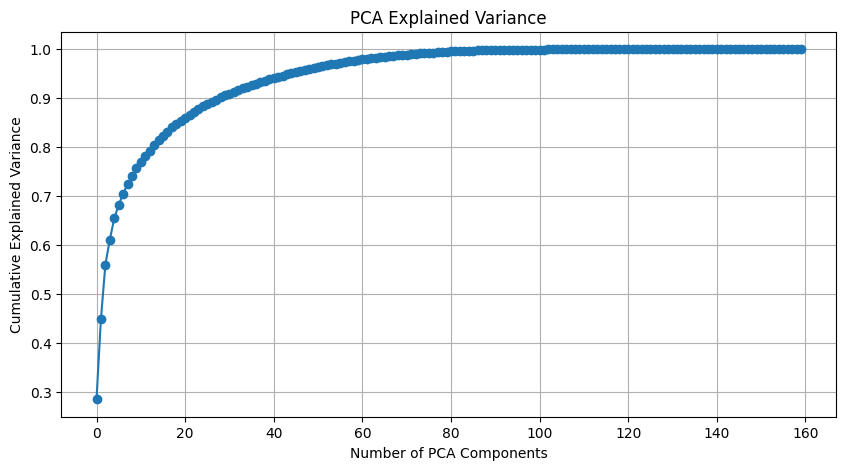

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load Dataset
df =filtered_df.copy()  # Replace with the actual file
df.drop(columns=["Open Time"], inplace=True)  # Remove timestamp column

# Identify Price & Indicator Columns
price_columns = [col for col in df.columns if col.endswith("_Close")]
indicator_columns = [col for col in df.columns if col not in price_columns]

# Apply Log Scaling to Prices
df[price_columns] = np.log1p(df[price_columns])  # log(1 + x) transformation

# Standardize Indicator Columns
scaler = StandardScaler()
scaled_indicators = scaler.fit_transform(df[indicator_columns])

# Fit PCA
pca = PCA(n_components=None)  # No limit, fit all components
pca.fit(scaled_indicators)

# Plot Explained Variance
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.xlabel("Number of PCA Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid()
plt.show()


In [ ]:
import gym
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from gym import spaces
import joblib  # For saving and loading scalers

class CryptoTradingEnv(gym.Env):
    def __init__(self, df, initial_balance=100000, window_size=24, log_interval=50, max_steps=None, pca_components=89):
        super(CryptoTradingEnv, self).__init__()

        self.df = df.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.window_size = window_size
        self.log_interval = log_interval
        self.rewards = []
        self.balances = []
        self.returns = []
        self.pca_components = pca_components

        # ✅ Apply the SAME preprocessing for training data
        self.scaler, self.pca, self.df_pca = self.preprocess_data(self.df, pca_components)

        # ✅ Save the scaler and PCA for later use
        joblib.dump(self.scaler, "model/scaler.pkl")
        joblib.dump(self.pca, "model/pca.pkl")

        # ✅ Identify columns
        self.price_columns = [col for col in df.columns if col.endswith("_Close")]

        # Normalize Balance & Holdings
        self.balance_scale = initial_balance
        self.holdings_scale = df[self.price_columns].max().max()

        # Define Action Space
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)

        # Define Observation Space
        num_features = self.df_pca.shape[1] - 1  # Exclude "Open Time"
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(window_size, num_features + 2), dtype=np.float32
        )

        self.max_steps = max_steps if max_steps is not None else len(self.df_pca) - self.window_size
        self.reset()

    @staticmethod
    def preprocess_data(df, pca_components=89):
        """Applies scaling and PCA transformation to input data"""
        price_columns = [col for col in df.columns if col.endswith("_Close")]
        indicator_columns = [col for col in df.columns if col not in price_columns + ["Open Time"]]

        # ✅ Standardize Data
        scaler = StandardScaler()
        all_features = price_columns + indicator_columns
        scaled_data = scaler.fit_transform(df[all_features])

        # ✅ Apply PCA to retain variance
        pca = PCA(n_components=pca_components)
        reduced_data = pca.fit_transform(scaled_data)

        # ✅ Create a new DataFrame with PCA components
        pca_columns = [f"PCA_{i+1}" for i in range(pca.n_components_)]
        df_pca = pd.DataFrame(reduced_data, columns=pca_columns)
        df_pca["Open Time"] = df["Open Time"]
        df_pca[price_columns] = df[price_columns]  # Keep original price data

        return scaler, pca, df_pca

    def _next_observation(self):
        """Fetch the last `window_size` steps as observation."""
        obs = self.df_pca.iloc[self.current_step - self.window_size:self.current_step].drop("Open Time", axis=1).values
        obs = np.array(obs, dtype=np.float32)

        # Normalize balance & holdings
        norm_balance = self.balance / self.balance_scale
        norm_holdings = (self.holdings * self.df_pca.iloc[self.current_step]["BTCUSDT_Close"]) / self.holdings_scale

        obs = np.hstack((obs, np.array([[norm_balance, norm_holdings]] * self.window_size)))
        return obs

    def reset(self):
        """Resets the environment."""
        self.current_step = self.window_size  
        self.balance = self.initial_balance
        self.holdings = 0
        self.rewards = []
        self.balances = []
        self.returns = []
        self.prev_value = self.initial_balance  # Track previous portfolio value
        self.port_value = self.initial_balance  # ✅ Initialize portfolio value
        return self._next_observation()

    def step(self, action):
        """Take action, update portfolio, and return reward."""
        current_price = self.df_pca.iloc[self.current_step]["BTCUSDT_Close"]
        done = False  

        # Tanh-scaling to avoid extreme trades
        trade_fraction = np.tanh(action[0])  

        # Transaction cost (0.1% per trade)
        tx_cost = 0.001  

        # Track previous portfolio value
        prev_portfolio_value = self.port_value  

        # Execute Trade
        if trade_fraction > 0:  # Buy
            cost = trade_fraction * self.balance * (1 + tx_cost)
            self.holdings += cost / (current_price * (1 + tx_cost))
            self.balance -= cost
        elif trade_fraction < 0 and self.holdings > 0:  # Sell only if it has holdings
            sell_amount = min(abs(trade_fraction) * self.holdings, self.holdings)
            if sell_amount > 0:  # Ensure it's worth selling
                sold_value = sell_amount * current_price
                self.balance += sold_value * (1 - tx_cost)
                self.holdings -= sell_amount

        # Compute New Portfolio Value
        portfolio_value = self.balance + (self.holdings * current_price)
        self.port_value = portfolio_value

        # Compute Logarithmic Return
        daily_return = np.log(portfolio_value / prev_portfolio_value)

        # **New Reward Function**
        realized_profit = self.balance - prev_portfolio_value  # Profit from selling
        unrealized_profit = self.port_value - prev_portfolio_value  # Change in total portfolio value
        position_size = abs(trade_fraction)

        # Price difference from the last 24-hour window
        past_price = self.df_pca.iloc[self.current_step - 1]["BTCUSDT_Close"]
        price_change = (current_price - past_price) / past_price

        # Encourage buying if price is low relative to past
        buy_bonus = 0.1 * (-price_change) if trade_fraction > 0 else 0

        reward = 1.0 * daily_return  # Increase weighting on return
        reward += 0.5 * (realized_profit / self.initial_balance) if realized_profit > 1 else 0
        reward -= 0.03 * (action[0] ** 2)  # Smaller penalty for action size
        reward -= 0.02 if abs(action[0]) < 0.1 else 0  # Reduce inaction penalty
        reward += 0.2 * buy_bonus  # Boost incentive for buying at dips

        reward = np.clip(reward, -5, 5)  # Prevent extreme values

        self.rewards.append(reward)
        self.balances.append(self.balance)

        # Terminate if bankruptcy occurs
        risk_of_ruin = (self.balance + (self.holdings * current_price)) < 0.05 * self.initial_balance and self.balance < 0.1 * self.initial_balance
        if self.current_step >= self.max_steps or risk_of_ruin:
            done = True
            print(f"❌ Episode Terminated: Bankruptcy at Step {self.current_step} | Portfolio Value: {self.port_value:.2f}")

        # Log Every Few Steps
        if self.current_step % self.log_interval == 0 or done:
            print(
                f"📊 Step {self.current_step}, Action: {action[0]:.4f}, Reward: {reward:.4f}, "
                f"Balance: {self.balance:.2f}, Holdings: {self.holdings:.6f}, Portfolio Value: {self.port_value:.2f}"
            )

        self.current_step += 1
        return self._next_observation(), reward, done, {}

    def calculate_sharpe_ratio(self, returns, risk_free_rate=0.02):
        """Calculate Sharpe Ratio using rolling returns."""
        if len(returns) < 5:
            return -1  
        excess_returns = np.array(returns[-10:]) - risk_free_rate
        std = max(excess_returns.std(), 1e-4)
        sharpe = excess_returns.mean() / std
        return np.clip(sharpe, -3, 3)

    def get_rewards(self):
        return self.rewards

    def get_balances(self):
        return self.balances


In [120]:
train_env = CryptoTradingEnv(train_df)
test_env = CryptoTradingEnv(test_df)

In [ ]:
model = RecurrentPPO(
    "MlpLstmPolicy", train_env,
    verbose=1,
    learning_rate=0.0001,  
    gamma=0.90,  # Focus more on short-term rewards
    clip_range=0.2,  # Allow larger updates
    ent_coef=0.1, # Allow for more exploration
    device="mps"  #Use Apple GPU
) 
model.learn(total_timesteps=100000)

# Save Model
model.save("model/ppo_crypto_trading_bot_lstm")

Using mps device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/opt/anaconda3/envs/ds/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


📊 Step 50, Action: -0.2495, Reward: -0.0200, Balance: 28309.92, Holdings: 9.769457, Portfolio Value: 94414.27
📊 Step 100, Action: -0.6657, Reward: -0.0100, Balance: 71712.36, Holdings: 4.192798, Portfolio Value: 102104.28
📊 Step 150, Action: 1.0000, Reward: -0.0320, Balance: 15840.38, Holdings: 11.300554, Portfolio Value: 102831.02
----------------------------
| time/              |     |
|    fps             | 113 |
|    iterations      | 1   |
|    time_elapsed    | 1   |
|    total_timesteps | 128 |
----------------------------
📊 Step 200, Action: -0.1836, Reward: -0.0013, Balance: 54606.47, Holdings: 6.701493, Portfolio Value: 113863.35
📊 Step 250, Action: -1.0000, Reward: -0.0214, Balance: 106433.30, Holdings: 1.642679, Portfolio Value: 121725.61
------------------------------------------
| time/                   |              |
|    fps                  | 33           |
|    iterations           | 2            |
|    time_elapsed         | 7            |
|    total_timesteps   

In [ ]:
model = RecurrentPPO.load('model/ppo_crypto_trading_bot_lstm.zip')

In [123]:
mean_reward, std_reward = evaluate_policy(model, train_env, n_eval_episodes=10)
print(f"📈 New Mean Reward: {mean_reward:.2f} ± {std_reward:.2f}")


/opt/anaconda3/envs/ds/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/opt/anaconda3/envs/ds/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


📊 Step 50, Action: 0.0056, Reward: -0.0221, Balance: 86051.15, Holdings: 1.928782, Portfolio Value: 99102.12
📊 Step 100, Action: 0.0056, Reward: -0.0183, Balance: 65035.91, Holdings: 4.967830, Portfolio Value: 101045.73
📊 Step 150, Action: 0.0056, Reward: -0.0223, Balance: 49152.94, Holdings: 7.161180, Portfolio Value: 104279.06
📊 Step 200, Action: 0.0056, Reward: -0.0202, Balance: 37148.89, Holdings: 8.571349, Portfolio Value: 112939.68
📊 Step 250, Action: 0.0056, Reward: -0.0074, Balance: 28076.45, Holdings: 9.559003, Portfolio Value: 117064.74
📊 Step 300, Action: 0.0056, Reward: -0.0124, Balance: 21219.67, Holdings: 10.277853, Portfolio Value: 114561.17
📊 Step 350, Action: 0.0056, Reward: -0.0212, Balance: 16037.43, Holdings: 10.844432, Portfolio Value: 119499.83
📊 Step 400, Action: 0.0056, Reward: -0.0224, Balance: 12120.80, Holdings: 11.249537, Portfolio Value: 121769.93
📊 Step 450, Action: 0.0056, Reward: -0.0255, Balance: 9160.68, Holdings: 11.559124, Portfolio Value: 119019.63


In [58]:
import matplotlib.pyplot as plt

# ✅ Run the trained model in test environment
obs = test_env.reset()
done = False
rewards = []
cumulative_rewards = [0]

while not done:
    action, _ = model.predict(obs)
    obs, reward, done, _ = test_env.step(action)
    rewards.append(reward)
    cumulative_rewards.append(cumulative_rewards[-1] + reward)  # Track total profit

# ✅ Plot Rewards Per Step
plt.figure(figsize=(10,5))
plt.plot(rewards, label="Step Reward")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("RL Trading Bot - Step Rewards")
plt.legend()
plt.show()

# ✅ Plot Cumulative Profit
plt.figure(figsize=(10,5))
plt.plot(cumulative_rewards, label="Cumulative Reward")
plt.xlabel("Timesteps")
plt.ylabel("Total Profit")
plt.title("Cumulative Profit Over Time")
plt.legend()
plt.show()


ValueError: Error: Unexpected observation shape (24, 69) for Box environment, please use (24, 89) or (n_env, 24, 89) for the observation shape.

In [268]:
np.log(0.01)

np.float64(-4.605170185988091)

In [59]:
test_df

,Open Time,BTCUSDT_Close,BTCUSDT_Volume,ETHUSDT_Close,ETHUSDT_Volume,XRPUSDT_Close,XRPUSDT_Volume,BNBUSDT_Close,BNBUSDT_Volume,USDCUSDT_Close,...,VETUSDT_MFI_14,ALGOUSDT_EMA_10,ALGOUSDT_EMA_50,ALGOUSDT_RSI_14,ALGOUSDT_MACD,ALGOUSDT_MACD_Signal,ALGOUSDT_BB_Upper,ALGOUSDT_BB_Middle,ALGOUSDT_OBV,ALGOUSDT_MFI_14
9636,2024-08-17 00:00:00,59158.37,1769.95814,2595.77,17799.5792,0.5629,10873045.0,521.40,21129.665,0.9996,...,31.147353,0.116568,0.118502,43.198327,-0.000890,-0.000519,0.122473,0.118180,1.573923e+09,38.870386
9637,2024-08-17 04:00:00,59248.00,1106.84453,2600.24,10808.4453,0.5647,9080091.0,523.20,16892.796,0.9997,...,34.845781,0.116556,0.118423,46.783923,-0.000848,-0.000585,0.122040,0.117940,1.576071e+09,39.002416
9638,2024-08-17 08:00:00,59137.12,1327.01136,2599.23,14186.2746,0.5649,11448854.0,529.60,34690.602,0.9998,...,31.633558,0.116400,0.118317,44.755582,-0.000869,-0.000642,0.121771,0.117710,1.573585e+09,39.457711
9639,2024-08-17 12:00:00,59388.11,1490.86412,2606.78,19916.7500,0.5668,16751370.0,534.40,54677.666,0.9999,...,35.747558,0.116473,0.118257,48.088289,-0.000788,-0.000671,0.121470,0.117545,1.577122e+09,43.776009
9640,2024-08-17 16:00:00,59473.19,1157.01055,2614.94,15643.5968,0.5672,12312347.0,544.50,30915.925,0.9999,...,35.101156,0.116623,0.118220,49.577296,-0.000676,-0.000672,0.121023,0.117375,1.579758e+09,43.404609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10748,2025-02-18 08:00:00,95640.34,2483.18123,2679.26,88680.2452,2.5735,28661750.0,655.47,59007.049,1.0002,...,38.812665,0.269545,0.284263,29.408649,-0.006980,-0.005297,0.295782,0.277305,2.708155e+09,32.012922
10749,2025-02-18 12:00:00,95546.48,4474.04458,2673.70,114342.8765,2.5407,41041883.0,648.18,66310.534,1.0001,...,38.451480,0.266318,0.282990,24.968354,-0.007995,-0.005837,0.294615,0.275090,2.693925e+09,29.499088
10750,2025-02-18 16:00:00,94104.14,6846.15491,2630.37,139482.6642,2.5117,57299893.0,640.94,107680.905,1.0004,...,31.645680,0.263551,0.281740,24.618100,-0.008756,-0.006421,0.293357,0.272995,2.679070e+09,22.793403
10751,2025-02-18 20:00:00,95671.74,4785.98483,2671.99,63593.5735,2.5628,27097647.0,648.18,24791.233,1.0004,...,37.440577,0.262451,0.280789,33.766374,-0.008742,-0.006885,0.291547,0.271440,2.685181e+09,27.651355
